In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
line = xt.Line.from_json('pimms_00_optics.json')
tw = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/220 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [4]:
line.vars['kse1'] = 1
line.vars['kse2'] = -8

In [5]:
def characterize_phase_space_at_septum(line, num_turns=2000, plot=False):
    x = np.linspace(0, 2.5e-2, 20)
                                       
    # Localize transition between stable and unstable
    x_septum = 3.5e-2

    x_stable = 0
    x_unstable = 3e-2
    while x_unstable - x_stable > 1e-6:
        x_test = (x_stable + x_unstable) / 2
        p = line.build_particles(x=x_test, px=0)
        line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
        mon_test = line.record_last_track
        if (mon_test.x > x_septum).any():
            x_unstable = x_test
        else:
            x_stable = x_test 
    
    p = line.build_particles(x=[x_stable, x_unstable], px=0)
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    mon_separatrix = line.record_last_track
    nc_sep = tw.get_normalized_coordinates(mon_separatrix)                                
    

    z_triang = nc_sep.x_norm[0, :] + 1j * nc_sep.px_norm[0, :]
    r_triang = np.abs(z_triang)
    
    # height of separatrix
    h_separatrix = np.min(np.abs(r_triang))
    
    # Find fixed points
    i_fp1 = np.argmax(r_triang)
    z_fp1 = z_triang[i_fp1]
    r_fp1 = np.abs(z_fp1)

    mask_fp2 = np.abs(z_triang - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp2 = np.argmax(r_triang * mask_fp2)

    mask_fp3 = np.abs(z_triang - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp3 = np.argmax(r_triang * mask_fp3)

    x_norm_fp = np.array([nc_sep.x_norm[0, i_fp1],
                          nc_sep.x_norm[0, i_fp2],
                          nc_sep.x_norm[0, i_fp3]])
    px_norm_fp = np.array([nc_sep.px_norm[0, i_fp1],
                           nc_sep.px_norm[0, i_fp2],
                           nc_sep.px_norm[0, i_fp3]])

    # Measure slope of the separatrix at the semptum
    x_separ = mon_separatrix.x[1, :]
    px_separ = mon_separatrix.px[1, :]
    x_norm_separ = nc_sep.x_norm[1, :]
    px_norm_separ = nc_sep.px_norm[1, :]
    i_septum = np.argmin(np.abs(x_separ - x_septum))

    poly_sep = np.polyfit([x_separ[i_septum + 3], x_separ[i_septum - 3]],
                             [px_separ[i_septum + 3], px_separ[i_septum - 3]],
                              deg=1)
    slope_separatrix = poly_sep[0]

    if plot:
        particles = line.build_particles(x=x, px=0)
        line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
        mon = line.record_last_track
        nc = tw.get_normalized_coordinates(mon) 

        plt.figure(figsize=(10, 5))
        ax_geom = plt.subplot(1, 2, 1)
        plt.plot(mon.x.T, mon.px.T, '.', markersize=1, color='C0')
        plt.ylabel(r'$p_x$')
        plt.xlabel(r'$x$ [m]')
        plt.xlim(-5e-2, 5e-2)
        plt.ylim(-5e-3, 5e-3)
        ax_norm = plt.subplot(1, 2, 2)
        plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
                 '.', markersize=1, color='C0')
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.gca().set_aspect('equal', adjustable='datalim')

        plt.xlabel(r'$\hat{x}$ [$10^{-3}$]')
        plt.ylabel(r'$\hat{y}$ [$10^{-3}$]')

        # Plot separatrix
        ax_geom.plot(mon_separatrix.x[0, :], mon_separatrix.px[0, :], '.', color='C2')
        ax_geom.plot(mon_separatrix.x[1, :], mon_separatrix.px[1, :], '.', color='C1')
        ax_norm.plot(nc_sep.x_norm[0, :] * 1e3, nc_sep.px_norm[0, :] * 1e3, '.', color='C2')
        ax_norm.plot(nc_sep.x_norm[1, :] * 1e3, nc_sep.px_norm[1, :] * 1e3, '.', color='C1')
        ax_norm.plot(x_norm_fp*1e3, px_norm_fp*1e3, '*', markersize=10, color='k')

        x_plt = [x_septum - 1e-2, x_septum + 1e-2]
        ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)
                                       
    return {
        'h_separatrix': h_separatrix,
        'slope_at_septum': slope_separatrix,
        'x_norm_fp': x_norm_fp,
        'px_norm_fp': x_norm_fp
    }

In [6]:
%time characterize_phase_space_at_septum(line, num_turns=1000)

CPU times: user 796 ms, sys: 6.75 ms, total: 803 ms
Wall time: 800 ms


{'h_separatrix': 0.004085501235424226,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774364]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774364])}

<IPython.core.display.Javascript object>


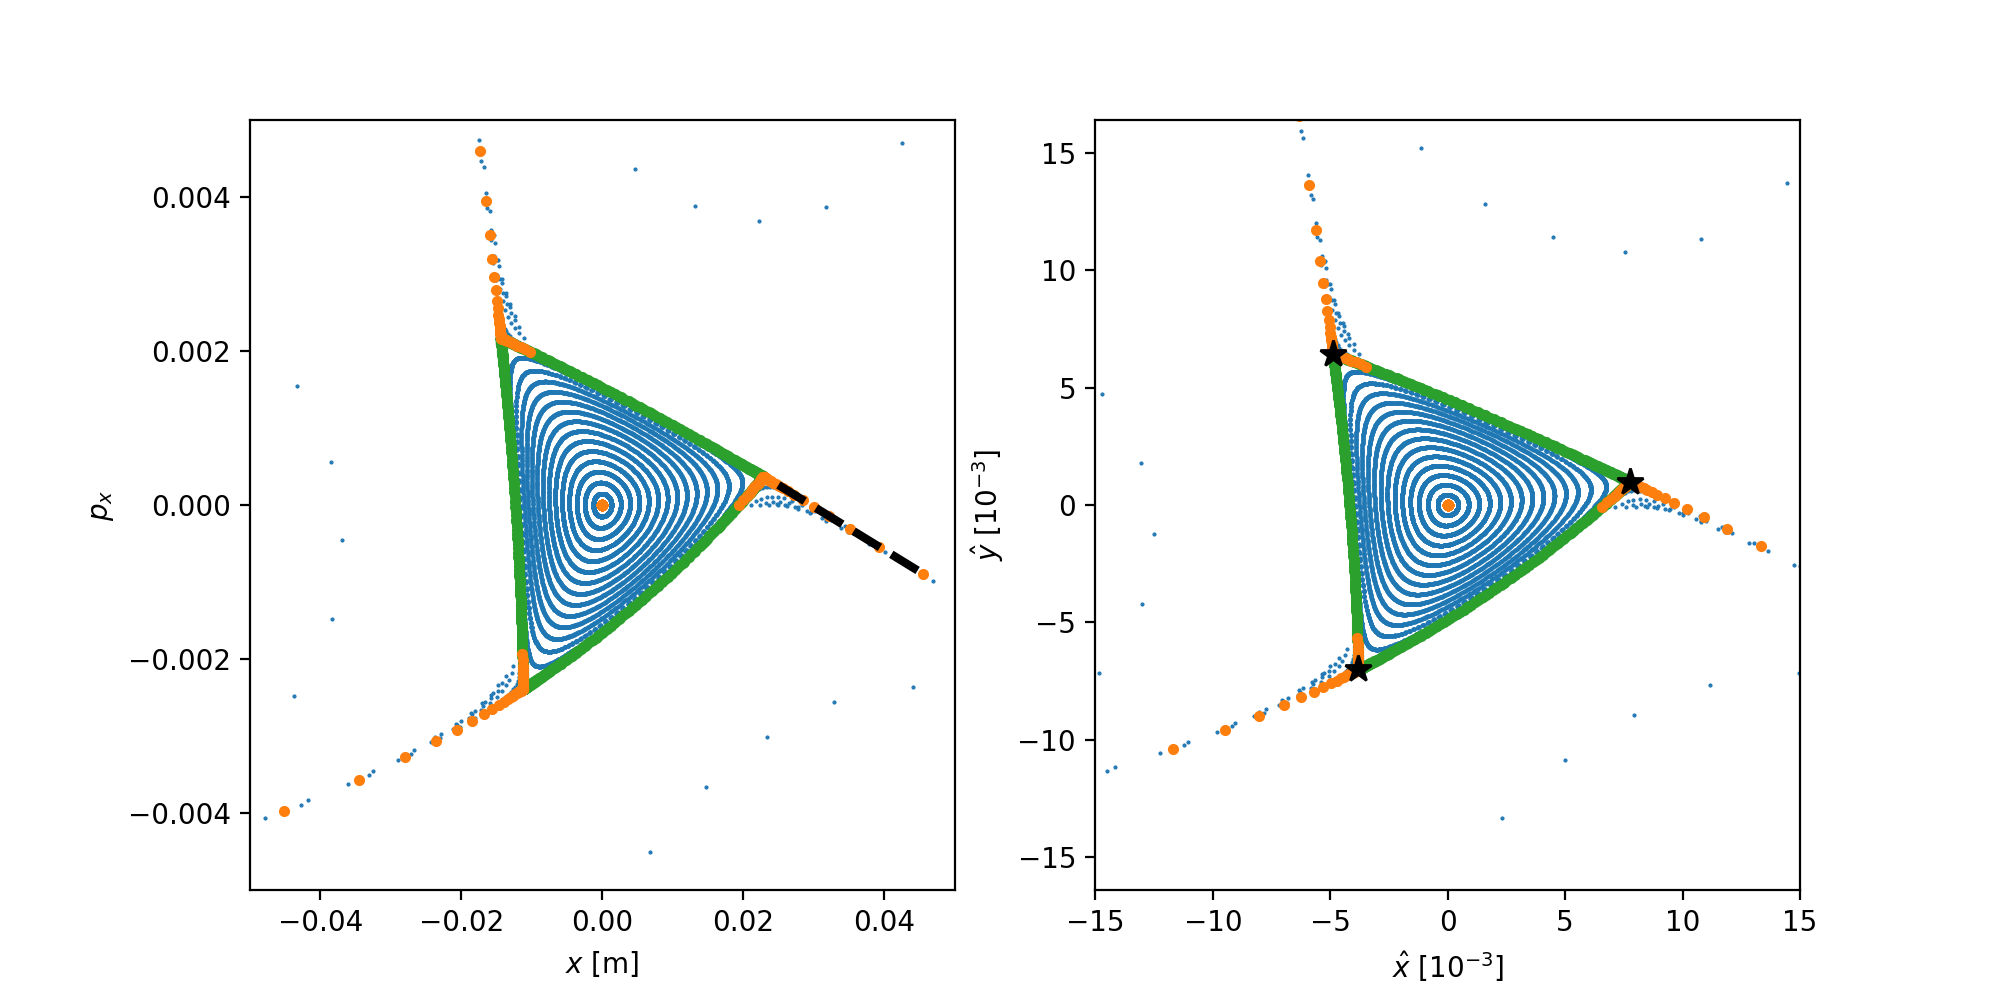

{'h_separatrix': 0.004085501235424226,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774364]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774364])}

In [7]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [11]:
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out

In [12]:
action = ActionSeparatrix(line)

In [13]:
action.run()

{'h_separatrix': 0.004084825781998476,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774359]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774359])}

In [17]:
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, tag='resonance',
                     limits=[-10, 10]),
    targets=[
        action.target('h_separatrix', 4e-3, tol=1e-4, weight=10),
        action.target('slope_at_septum', 0.05, tol=0.01)
    ]
)

In [15]:
opt.target_status()

Target status:                  
id state tag tol_met     residue current_val target_val description                                 
 0 ON          False 8.48258e-05  0.00408483      0.004 'h_separatrix', val=0.004, tol=5e-05, we ...
 1 ON          False   -0.106178  -0.0561784       0.05 'slope_at_septum', val=0.05, tol=0.01, w ...


In [ ]:
opt.step(20)

In [ ]:
opt.log()

In [18]:
opt.reload(0)

In [19]:
def err_fun(x):
    out = opt._err(x, check_limits=False)
    print(f'x = {x}, out = {out}')
    return out

bounds = np.array([vv.limits for vv in opt._err.vary])
opt._err.return_scalar = True
import pybobyqa
soln = pybobyqa.solve(err_fun, x0=opt.log().vary[0, :], bounds=bounds.T,
            rhobeg=10, rhoend=1e-4, maxfun=30, objfun_has_noise=True,
            seek_global_minimum=True)
err_fun(soln.x) # set it to the best solution
opt.tag('pybobyqa')
opt.target_status()

x = [1.06353941 7.02446594], out = 1.6724436622533586e-06
x = [10.          7.02446594], out = 0.0012702889520864176
x = [ 1.06353941 10.        ], out = 0.000211428261202442
x = [-8.93646059  7.02446594], out = 0.022164040487098857
x = [ 1.06353941 -2.97553406], out = 15626.483237617806
x = [10. 10.], out = 0.0013404503481008103
x = [4.99315647 8.51223276], out = 0.0005854520872272457
x = [-6.08760667  9.86596815], out = 0.0005254005350585017
x = [8.18587393 8.57895974], out = 0.001174040240679719
x = [-2.62051264  8.43745917], out = 0.013980364718016112
x = [7.29233841 6.79702634], out = 0.019080150853521764
x = [1.44077344 8.47128578], out = 8.996366954725146e-05
x = [-1.36579214  5.88548847], out = 0.0005498248776381973
x = [-0.96182408  8.56036458], out = 0.05329301306877307
x = [0.63804638 4.64747581], out = 0.00035748354288868964
x = [2.75552508 8.56416099], out = 0.029730183074564275
x = [-0.29154701  5.3253623 ], out = 0.0004353745354739075
x = [0.19920081 5.1557673 ], out = 0